# Imports and Dependencies

In [2]:
import os
# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/Drone_Recog/")

Mounted at /content/gdrive


In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.utils import plot_model, to_categorical, image_dataset_from_directory
from tensorflow.keras import optimizers

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2

In [4]:
h, w = 240, 360
epochs = 500
frame_seq = 20
OF_path = 'datasets/OF'
img_path = 'datasets/Images'

class_names = os.listdir(OF_path)
num_class = len(class_names)

# Preparing Dataset

Normal Images

In [5]:
# Normal Images
img_feature = []
img_labels = []

for idx, class_name in enumerate(class_names):
    print(f'Getting frames from {class_name}')
    imgfile_path = os.path.join(img_path, class_name)
    #OFfile_path = os.path.join(OF_path, class_name)
    img_files = os.listdir(imgfile_path)
    for vid_name in img_files:
        print(f'Extracting frames from: {vid_name}')
        imgframe_path = os.path.join(imgfile_path, vid_name)
        img_frames = os.listdir(imgframe_path) 

        frame_list = []
        for i, frames in enumerate(img_frames):
            if i < 20:
                frame_path = os.path.join(imgframe_path, frames)
                frame = cv2.resize(cv2.imread(frame_path), (w,h))
                frame = frame / 255
                frame_list.append(frame)
  
        # 2 appended lists to get a sequence of images
        img_feature.append(frame_list)
        img_labels.append(idx)

Getting frames from clapping
Extracting frames from: S3_clapping_HD


KeyboardInterrupt: ignored

In [ ]:
# converting to array
img_features = np.asarray(img_feature)
img_labels = np.array(img_labels)

print(img_features.shape)
print(img_labels.shape)

In [ ]:
# saving to numpy arrays
if not os.path.exists('image_array'):
    os.makedirs('image_array')
    print("Created new directory 'image_array'")
np.save(f'image_array/{h}x{w}_imgfeatures', img_features)
np.save(f'image_array/{h}x{w}_imglabels', img_labels)

OF Images

In [ ]:
# Normal Images
OF_feature = []
OF_labels = []

for idx, class_name in enumerate(class_names):
    print(f'Getting frames from {class_name}')
    OFfile_path = os.path.join(OF_path, class_name)
    OF_files = os.listdir(OFfile_path)
    for vid_name in OF_files:
        print(f'Extracting frames from: {vid_name}')
        OFframe_path = os.path.join(OFfile_path, vid_name)
        OF_frames = os.listdir(OFframe_path) 
        frame_list = []
        for i, frames in enumerate(OF_frames):
            if i < 20:
                frame_path = os.path.join(OFframe_path, frames)
                frame = cv2.imread(frame_path) / 255
                frame_list.append(frame)
    
        # 2 appended lists to get a sequence of images
        OF_feature.append(frame_list)
        OF_labels.append(idx)

In [ ]:
# converting to array
OF_features = np.asarray(OF_feature)
OF_labels = np.array(OF_labels)

print(OF_features.shape)
print(OF_labels.shape)

In [ ]:
# saving to numpy arrays
if not os.path.exists('image_array'):
    os.makedirs('image_array')
    print("Created new directory 'image_array'")
np.save(f'image_array/{h}x{w}_OFfeatures', OF_features)
np.save(f'image_array/{h}x{w}_OFlabels', OF_labels)

#Plotting

In [6]:
def plot_graph(training_history, metric1, metric2, plot_name):
    """
    Function to plot and show graph of accuracy and loss
    :param training_history: record of training and validation (acc/loss)
    :param metric1: first metric
    :param metric2: second metric
    :param plot_name: name of plot
    """

    # Get metric values using metric names as identifiers.
    metric_1 = training_history.history[metric1]
    metric_2 = training_history.history[metric2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_1))

    # Plotting
    plt.plot(epochs, metric_1, 'blue', label=metric1)
    plt.plot(epochs, metric_2, 'red', label=metric2)

    # Add title
    plt.title(str(plot_name))

    # Legends
    plt.legend()
    plt.show()

# Model

## *Build Models*

In [7]:
# RGB CNN
def build_rgb_cnn():
    In = Input(shape=(frame_seq, h, w, 3), name = 'rgb-cnn input')
    x = TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'), name = 'conv1')(In)
    x = TimeDistributed(MaxPooling2D(4), name = 'pooling1')(x)

    x = TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu'), name = 'conv2')(x)
    x = TimeDistributed(MaxPooling2D(2), name = 'pooling2')(x)

    x = TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu'), name = 'conv3a')(x)
    x = TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu'), name = 'conv3b')(x)
    x = TimeDistributed(MaxPooling2D(2), name = 'pooling3')(x)

    return Model(In, x, name = 'RGB-CNN_Model')

In [13]:
# OF CNN
def build_of_cnn():
    In = Input(shape=(frame_seq, h, w, 3), name = 'of-cnn input')
    x = TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu'), name = 'conv1')(In)
    x = TimeDistributed(MaxPooling2D(4), name = 'pooling1')(x)

    x = TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu'), name = 'conv2')(x)
    x = TimeDistributed(MaxPooling2D(2), name = 'pooling2')(x)

    x = TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu'), name = 'conv3a')(x)
    x = TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu'), name = 'conv3b')(x)
    x = TimeDistributed(MaxPooling2D(2), name = 'pooling3')(x)

    return Model(In, x, name = 'OF-CNN_Model')

In [44]:
# RGB-OF LRCN
def build_rgbof_cnn():
    In = Input(shape=(frame_seq, 15, 22, 256), name = 'rgb-of lrcn input')
    x = TimeDistributed(Conv2D(256, (3, 3), padding='same', activation='relu'), name = 'conv1a')(In)
    x = TimeDistributed(Conv2D(256, (3, 3), padding='same', activation='relu'), name = 'conv1b')(x)
    x = TimeDistributed(MaxPooling2D(2), name = 'pooling1')(x)

    x = TimeDistributed(Conv2D(256, (3, 3), padding='same', activation='relu'), name = 'conv2a')(x)
    x = TimeDistributed(Conv2D(256, (3, 3), padding='same', activation='relu'), name = 'conv2b')(x)
    x = TimeDistributed(MaxPooling2D(2), name = 'pooling2')(x)

    return Model(In, x, name = 'RGB-OF-CNN_Model')



## *Final Model*

In [45]:
# inputs for both models
RGB_input = Input(shape=(frame_seq, h, w, 3), name = 'RGB_Input')
OF_input = Input(shape=(frame_seq, h, w, 3), name = 'OF_Input')

# build all models
rgb_model = build_rgb_cnn()
of_model = build_of_cnn()
rgbof_model = build_rgbof_cnn()

# passing input through both models
rgb_cnn = rgb_model(RGB_input)
of_cnn = of_model(OF_input)

In [46]:
RGB_OF_Model = Concatenate(axis=-1, name = 'concatenate')([rgb_cnn, of_cnn])

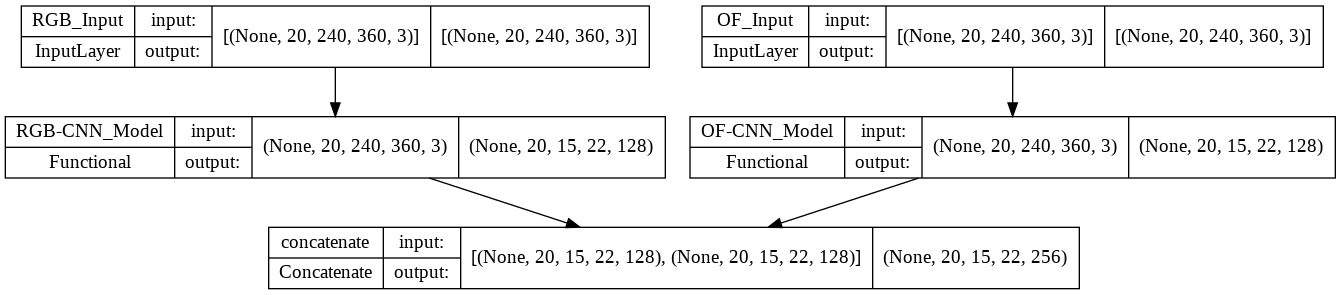

In [47]:
# half checkpoint
model = Model((RGB_input, OF_input), RGB_OF_Model)
plot_model(model, show_shapes = True)

In [48]:
# combined model to next cnn model
rgbof_cnn = rgbof_model(RGB_OF_Model)

# LSTM model
x = TimeDistributed(Flatten(), name = 'flatten')(rgbof_cnn)
x = Dropout(0.5, name = 'dropout')(x)
x = tf.keras.layers.LSTM(512, name = 'LSTM')(x)
LRCN_output = Dense(num_class, activation = 'softmax')(x)

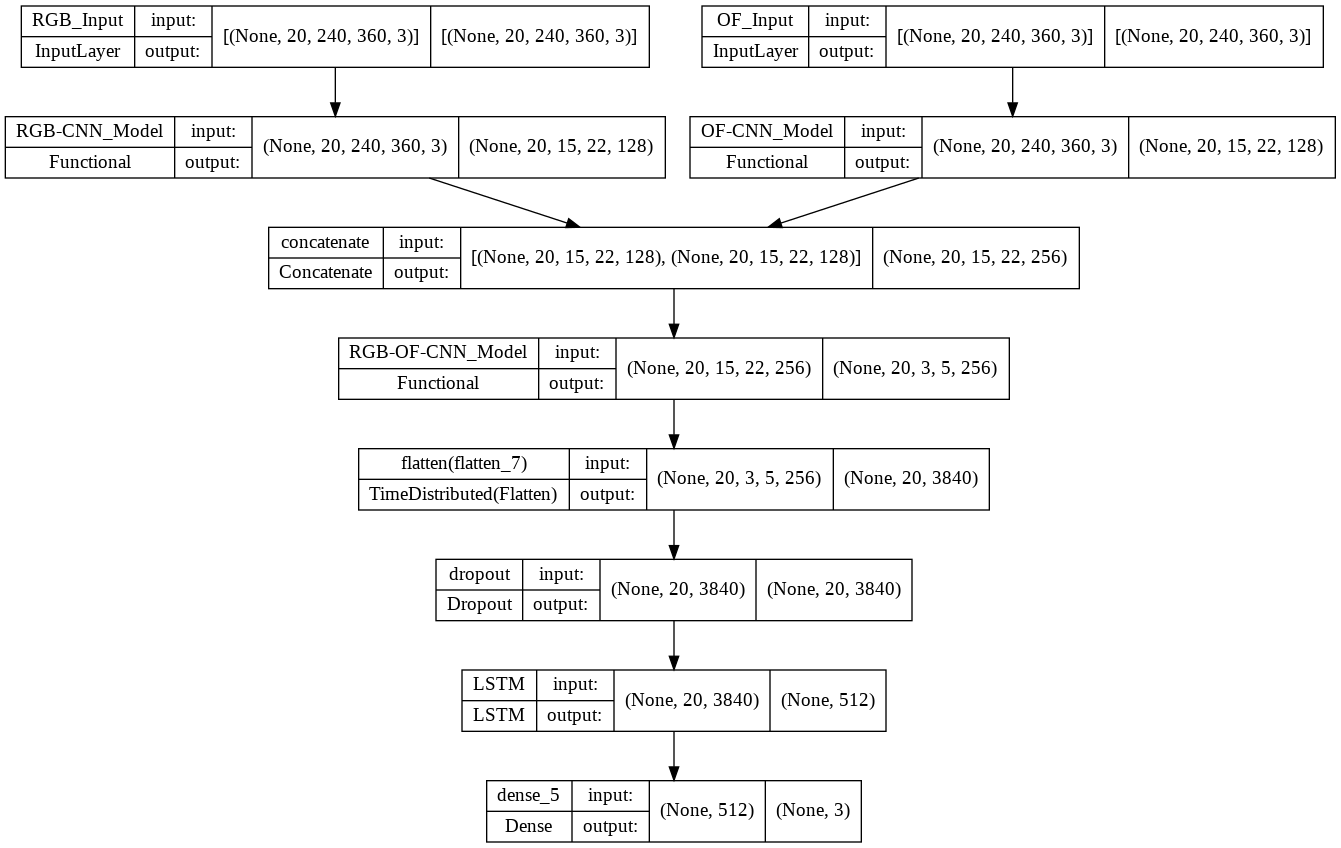

In [49]:
LRCN_model = Model((RGB_input, OF_input), LRCN_output)
plot_model(LRCN_model, show_shapes = True)

In [50]:
LRCN_model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 RGB_Input (InputLayer)         [(None, 20, 240, 36  0           []                               
                                0, 3)]                                                            
                                                                                                  
 OF_Input (InputLayer)          [(None, 20, 240, 36  0           []                               
                                0, 3)]                                                            
                                                                                                  
 RGB-CNN_Model (Functional)     (None, 20, 15, 22,   240832      ['RGB_Input[0][0]']              
                                128)                                                       

# Training

In [51]:
# load data
rgb_features = np.load(f'image_array/{h}x{w}_imgfeatures.npy')
rgb_labels = np.load(f'image_array/{h}x{w}_imglabels.npy')
OF_features = np.load(f'image_array/{h}x{w}_OFfeatures.npy')
OF_labels = np.load(f'image_array/{h}x{w}_OFlabels.npy')

rgb_labels = to_categorical(rgb_labels, num_classes=num_class)
OF_labels = to_categorical(OF_labels, num_classes=num_class)

In [57]:
# split datasets for training and testing
rgbtrain_feat, rgbtest_feat, rgbtrain_labels, rgbtest_labels = train_test_split(
    rgb_features, rgb_labels, test_size=0.1, shuffle=True, random_state=123)
oftrain_feat, oftest_feat, oftrain_labels, oftest_labels = train_test_split(
    OF_features, OF_labels, test_size=0.1, shuffle=True, random_state=123)

In [58]:
# using only rgb for testing
rgbtrain_feat = tf.stack(rgbtrain_feat)
rgbtrain_labels = tf.stack(rgbtrain_labels)
rgbtest_feat = tf.stack(rgbtest_feat)
rgbtest_labels = tf.stack(rgbtest_labels)

oftrain_feat = tf.stack(oftrain_feat)
oftrain_labels = tf.stack(oftrain_labels)
oftest_feat = tf.stack(oftest_feat)
oftest_labels = tf.stack(oftest_labels)

print(rgbtrain_feat.shape)
print(oftrain_feat.shape)

(36, 20, 240, 360, 3)
(36, 20, 240, 360, 3)


In [52]:
LRCN_model.compile(loss = 'categorical_crossentropy', # measures model accuracy
              optimizer = optimizers.Adam(learning_rate = 0.00001),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [53]:
# Run Training
LRCN_history = LRCN_model.fit([rgb_features, OF_features], 
                              rgb_labels,
                              validation_split=0.3,
                              batch_size = 2,
                              epochs=epochs)

Epoch 1/500
14/14 [==============================] - 17s 311ms/step - loss: 1.0666 - categorical_accuracy: 0.5000 - val_loss: 1.2148 - val_categorical_accuracy: 0.1667
Epoch 2/500
14/14 [==============================] - 3s 204ms/step - loss: 0.9638 - categorical_accuracy: 0.6429 - val_loss: 1.4951 - val_categorical_accuracy: 0.1667
Epoch 3/500
14/14 [==============================] - 3s 205ms/step - loss: 0.8064 - categorical_accuracy: 0.6429 - val_loss: 2.3395 - val_categorical_accuracy: 0.1667
Epoch 4/500
14/14 [==============================] - 3s 206ms/step - loss: 0.7233 - categorical_accuracy: 0.6429 - val_loss: 3.6268 - val_categorical_accuracy: 0.1667
Epoch 5/500
14/14 [==============================] - 3s 208ms/step - loss: 0.6564 - categorical_accuracy: 0.6429 - val_loss: 4.0229 - val_categorical_accuracy: 0.1667
Epoch 6/500
14/14 [==============================] - 3s 208ms/step - loss: 0.6573 - categorical_accuracy: 0.6429 - val_loss: 4.2702 - val_categorical_accuracy: 0.16

In [59]:
# Evaluate Accuracy
test_loss, test_acc = LRCN_model.evaluate([rgbtest_feat, oftest_feat], 
                                          [rgbtest_labels, oftest_labels], 
                                          verbose=2)
print(f'Test Accuracy: {test_acc}')

1/1 - 2s - loss: 3.8270 - categorical_accuracy: 0.7500 - 2s/epoch - 2s/step
Test Accuracy: 0.75


INFO:tensorflow:Assets written to: OF model results/LRCN_model__Loss_3.827017307281494__Acc_0.75/assets


INFO:tensorflow:Assets written to: OF model results/LRCN_model__Loss_3.827017307281494__Acc_0.75/assets


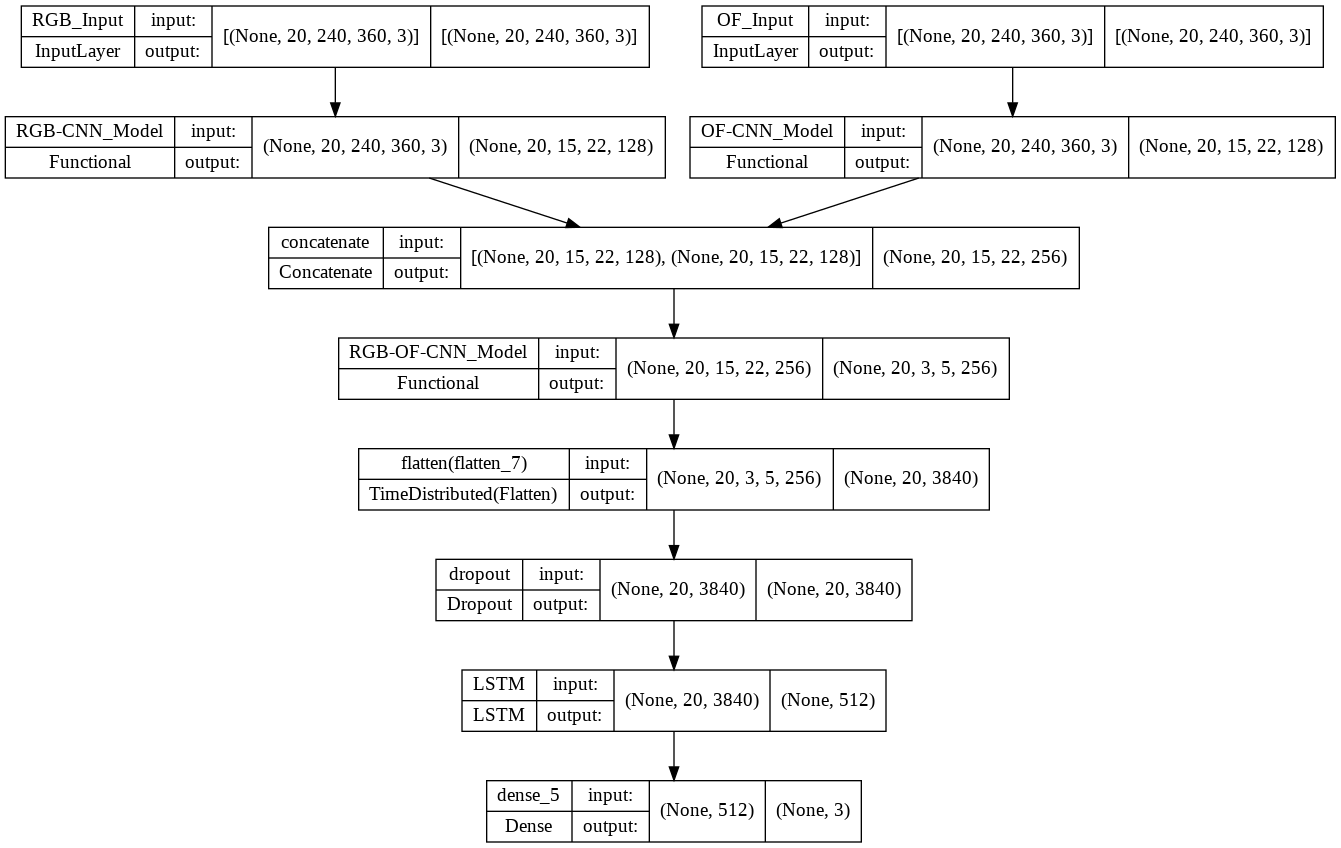

In [60]:
# saving model
file_name = f'OF model results/LRCN_model__Loss_{test_loss}__Acc_{test_acc}'
LRCN_model.save(file_name)
# plot model
plot_model(LRCN_model, show_shapes = True,to_file=f'OF model results/LRCN_model__Loss_{test_loss}__Acc_{test_acc}/LRCN_model.png')

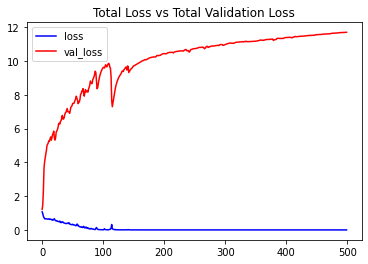

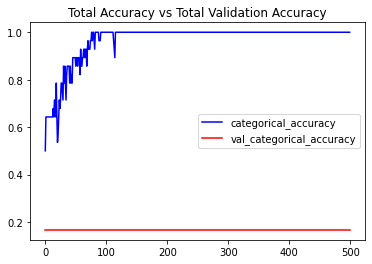

In [61]:
# plotting loss and accuracy
plot_graph(LRCN_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')
plot_graph(LRCN_history, 'categorical_accuracy', 'val_categorical_accuracy', 'Total Accuracy vs Total Validation Accuracy')